MPNN Pipeline: Train on Idealized -> Test on Realistic

Multi-output MPNN to predict both TAWSS and OSI on AV graft meshes, training on idealized meshes and testing on realistic ones.

Hypothesis: Applying nonlinearity to the edge representations (i.e. applying a transformation to edge features) before aggregating to the nodes will improve performance. Performance should beat previous augmented GNN model. Result: (HuberLoss down to 0.5588 from 0.5713)

Experiment:
Let's try ramping up the edge features to 16, adding another more GCNConv Layer and setting hidden number from 128 to 512.

In [ ]:
%pip install torch torch-geometric meshio numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip install tqdm trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.0/712.0 kB 37.5 MB/s eta 0:00:00


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/Realistic/
   creating: data/Idealized/
  inflating: data/Data description.txt  
   creating: data/Realistic/derived_cfd_metrics/
   creating: data/Idealized/derived_cfd_metrics/
  inflating: data/Realistic/derived_cfd_metrics/pt01rZCRCZ_turb_metric.h5  
  inflating: data/Realistic/derived_cfd_metrics/turbulenceZCRCZ.xdmf  
  inflating: data/Realistic/derived_cfd_metrics/pt01rBlock_wss_metrics.h5  
  inflating: data/Realistic/derived_cfd_metrics/pt01rZCRCZR_turb_metric.h5  
  inflating: data/Realistic/derived_cfd_metrics/pt01rBlock_turb_metric.h5  
  inflating: data/Realistic/derived_cfd_metrics/pt01rZCRCZR_wss_metrics.h5  
  inflating: data/Realistic/derived_cfd_metrics/pt01rZCRCZ_wss_metrics.h5  
  inflating: data/Realistic/derived_cfd_metrics/turbulenceBlock.xdmf  
  inflating: data/Realistic/derived_cfd_metrics/pt01rZCRCZ_wss_metrics.xdmf  
  inflating: data/Realistic/derived_cfd_metrics/turbulenceZCRCZR.xdmf  
  inflating: da

In [ ]:
import meshio, numpy as np, torch
import matplotlib.pyplot as plt
import torch_geometric

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
from collections import defaultdict
import trimesh


def build_edge_index(triangles, num_nodes):
    # Undirected edges from triangle list
    edges = set()
    for i, j, k in triangles:
        edges |= {(i, j), (j, k), (k, i)}
    edge_idx = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    return edge_idx

def angle_between_vectors_numpy(v1, v2, normalize=True, epsilon=1e-8):
    """Computes the angle in radians between pairs of vectors in NumPy arrays."""
    if normalize:
        v1_norm = np.linalg.norm(v1, axis=1, keepdims=True)
        v2_norm = np.linalg.norm(v2, axis=1, keepdims=True)
        v1 = v1 / (v1_norm + epsilon)
        v2 = v2 / (v2_norm + epsilon)
    dot_product = np.sum(v1 * v2, axis=1)
    dot_product = np.clip(dot_product, -1.0 + epsilon, 1.0 - epsilon)
    return np.arccos(dot_product)

def load_graph_with_edge_features(xdmf_path):
    """
    Loads a graph from an XDMF file and computes node and edge features.
    Handles non-triangular meshes by triangulating them.
    Node features: [coords (3), degree (1)].
    Edge features: [dihedral_angle (1), min_inner_angle (1), max_inner_angle (1),
                    min_edge_ratio (1), max_edge_ratio (1)].
    """
    # Load mesh
    mesh = meshio.read(xdmf_path)
    pts_np = mesh.points.astype(np.float32)

    # Check for triangular or non-triangular mesh
    if "triangle" in mesh.cells_dict:
        triangles_np = mesh.cells_dict["triangle"].astype(np.int64)
    else:
        # Handle non-triangular meshes (e.g., quads)
        faces = mesh.cells_dict.get("quad", None)
        if faces is None:
            raise ValueError(f"No triangle or quad cells found in {xdmf_path}. Available cells: {mesh.cells_dict.keys()}")
        # Triangulate using trimesh
        tri_mesh = trimesh.Trimesh(vertices=pts_np, faces=faces)
        tri_mesh.process(validate=True)
        tri_mesh = tri_mesh.subdivide()  # Subdivide ensures triangulation
        pts_np = tri_mesh.vertices.astype(np.float32)
        triangles_np = tri_mesh.faces.astype(np.int64)

    num_nodes = pts_np.shape[0]

    # 1. Compute unit normals for all faces
    v0 = pts_np[triangles_np[:, 0]]
    v1 = pts_np[triangles_np[:, 1]]
    v2 = pts_np[triangles_np[:, 2]]
    vec1 = v1 - v0
    vec2 = v2 - v0
    normals_np = np.cross(vec1, vec2)
    norms = np.linalg.norm(normals_np, axis=1, keepdims=True)
    unit_normals_np = normals_np / (norms + 1e-8)

    # 2. Build edge_index and edge_to_faces map
    edge_set = set()
    edge_to_faces = defaultdict(list)
    for i, face_v_indices in enumerate(triangles_np):
        e1 = tuple(sorted((face_v_indices[0], face_v_indices[1])))
        e2 = tuple(sorted((face_v_indices[1], face_v_indices[2])))
        e3 = tuple(sorted((face_v_indices[2], face_v_indices[0])))
        for edge in [e1, e2, e3]:
            edge_set.add(edge)
            edge_to_faces[edge].append(i)
    unique_edges_list = list(edge_set)
    num_edges = len(unique_edges_list)
    unique_edges_np = np.array(unique_edges_list)

    # Create PyTorch edge_index (undirected)
    edge_index = torch.tensor([[v1, v2] for v1, v2 in unique_edges_list] +
                              [[v2, v1] for v1, v2 in unique_edges_list],
                              dtype=torch.long).t().contiguous()

    # 3. Generate edge-face pairs
    edge_face_pairs = [(e_idx, f_idx) for e_idx, edge in enumerate(unique_edges_list)
                       for f_idx in edge_to_faces[edge]]
    edge_indices = np.array([pair[0] for pair in edge_face_pairs])
    face_indices = np.array([pair[1] for pair in edge_face_pairs])
    num_pairs = len(edge_face_pairs)

    # 4. Extract vertices for all pairs
    edge_vertices = unique_edges_np[edge_indices]
    face_vertices = triangles_np[face_indices]

    # 5. Find opposite vertices
    diff0 = face_vertices != edge_vertices[:, 0][:, None]
    diff1 = face_vertices != edge_vertices[:, 1][:, None]
    opposite_mask = diff0 & diff1
    opposite_vertex_indices = face_vertices[np.arange(num_pairs), np.argmax(opposite_mask, axis=1)]

    # 6. Get coordinates
    p_edge_v1_np = pts_np[edge_vertices[:, 0]]
    p_edge_v2_np = pts_np[edge_vertices[:, 1]]
    p_opposite_v_np = pts_np[opposite_vertex_indices]

    # 7. Compute inner angles
    vec_opp_to_e1 = p_edge_v1_np - p_opposite_v_np
    vec_opp_to_e2 = p_edge_v2_np - p_opposite_v_np
    inner_angles_rad = angle_between_vectors_numpy(vec_opp_to_e1, vec_opp_to_e2)

    # 8. Compute edge length ratios
    edge_len = np.linalg.norm(p_edge_v2_np - p_edge_v1_np, axis=1)
    vec_edge = p_edge_v2_np - p_edge_v1_np
    vec_e1_to_opp = p_opposite_v_np - p_edge_v1_np
    area = 0.5 * np.linalg.norm(np.cross(vec_edge, vec_e1_to_opp), axis=1)
    height = np.where(area < 1e-9, 1e-7, (2 * area) / (edge_len + 1e-8))
    edge_length_ratio_val = np.where(edge_len < 1e-7, 1.0,
                                     np.where(height < 1e-7, edge_len / 1e-7, edge_len / height))

    # 9. Aggregate features per edge
    sort_idx = np.argsort(edge_indices)
    sorted_edge_indices = edge_indices[sort_idx]
    sorted_inner_angles = inner_angles_rad[sort_idx]
    sorted_edge_ratios = edge_length_ratio_val[sort_idx]
    _, counts = np.unique(sorted_edge_indices, return_counts=True)
    split_points = np.cumsum(counts[:-1])
    inner_groups = np.split(sorted_inner_angles, split_points)
    ratio_groups = np.split(sorted_edge_ratios, split_points)
    min_inner_angles = np.array([np.min(g) for g in inner_groups])
    max_inner_angles = np.array([np.max(g) for g in inner_groups])
    min_edge_ratios = np.array([np.min(g) for g in ratio_groups])
    max_edge_ratios = np.array([np.max(g) for g in ratio_groups])

    # 10. Compute dihedral angles for internal edges
    internal_edge_indices = [i for i, edge in enumerate(unique_edges_list)
                             if len(edge_to_faces[edge]) == 2]
    internal_edge_faces = np.array([edge_to_faces[unique_edges_list[i]]
                                    for i in internal_edge_indices])
    n1 = unit_normals_np[internal_edge_faces[:, 0]]
    n2 = unit_normals_np[internal_edge_faces[:, 1]]
    dihedral_angles = angle_between_vectors_numpy(n1, n2)
    all_dihedral_angles = np.zeros(num_edges)
    all_dihedral_angles[internal_edge_indices] = dihedral_angles

    # 11. Assemble edge features
    edge_features_np = np.column_stack([
        all_dihedral_angles,
        min_inner_angles,
        max_inner_angles,
        min_edge_ratios,
        max_edge_ratios
    ])
    edge_features_np = np.nan_to_num(edge_features_np, nan=0.0, posinf=1.0, neginf=0.0)
    edge_features_tensor = torch.from_numpy(edge_features_np).float()

    # Duplicate edge features for undirected edges ([v1, v2] and [v2, v1])
    edge_attr = torch.cat([edge_features_tensor, edge_features_tensor], dim=0)

    # 12. Node features: coordinates and degree
    coords = torch.from_numpy(pts_np).float()
    deg = torch_geometric.utils.degree(edge_index[0], num_nodes=num_nodes).unsqueeze(1).float()
    x = torch.cat([coords, deg], dim=1)  # [N, 4]

    # 13. Target variables
    tawss = torch.tensor(mesh.point_data.get("tawss", np.zeros(num_nodes)), dtype=torch.float32)
    osi = torch.tensor(mesh.point_data.get("osi", np.zeros(num_nodes)), dtype=torch.float32)
    if tawss is None or osi is None:
        raise ValueError("TAWSS or OSI data missing.")
    if tawss.ndim == 1:
        tawss = tawss.unsqueeze(1)
    if osi.ndim == 1:
        osi = osi.unsqueeze(1)
    # y = torch.cat([tawss, osi], dim=1)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=tawss)

In [ ]:
from torch_geometric.loader import DataLoader

# Paths (unchanged)
real_paths = [
    r"data/Realistic/derived_cfd_metrics/pt01rBlock_wss_metrics.xdmf",
    r"data/Realistic/derived_cfd_metrics/pt01rZCRCZ_wss_metrics.xdmf",
    r"data/Realistic/derived_cfd_metrics/pt01rZCRCZR_wss_metrics.xdmf",
]
ideal_paths = [
    r"data/Idealized/derived_cfd_metrics/pt01iBlock_wss_metrics.xdmf",
    r"data/Idealized/derived_cfd_metrics/pt01iZCRCZ_wss_metrics.xdmf",
    r"data/Idealized/derived_cfd_metrics/pt01iZCRCZR_wss_metrics.xdmf",
]

# Load graphs
ideal_graphs = [load_graph_with_edge_features(p) for p in ideal_paths]
realistic_graphs = [load_graph_with_edge_features(p) for p in real_paths]

# Stack all train features/targets/edge attributes
all_x = torch.cat([g.x for g in ideal_graphs], dim=0)
all_y = torch.cat([g.y for g in ideal_graphs], dim=0)
all_edge_attr = torch.cat([g.edge_attr for g in ideal_graphs], dim=0)

# Compute stats
x_mean, x_std = all_x.mean(0), all_x.std(0)
y_mean, y_std = all_y.mean(0), all_y.std(0)
edge_attr_mean, edge_attr_std = all_edge_attr.mean(0), all_edge_attr.std(0)

# Normalization in-place helper
def normalize_graph(g):
    g.x = (g.x - x_mean) / (x_std + 1e-8)
    g.y = (g.y - y_mean) / (y_std + 1e-8)
    g.edge_attr = (g.edge_attr - edge_attr_mean) / (edge_attr_std + 1e-8)
    return g

# Apply
ideal_graphs = [normalize_graph(g) for g in ideal_graphs]
realistic_graphs = [normalize_graph(g) for g in realistic_graphs]

# Rebuild loaders
train_loader = DataLoader(ideal_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(realistic_graphs, batch_size=1)

In [ ]:
# import torch
# import matplotlib.pyplot as plt

# mesh = meshio.read("data/Idealized/derived_cfd_metrics/pt01iBlock_wss_metrics.xdmf")
# pts_np = mesh.points.astype(np.float32)
# num_nodes = pts_np.shape[0]
# tawss = torch.tensor(mesh.point_data.get("tawss", np.zeros(num_nodes)), dtype=torch.float32)
# osi = torch.tensor(mesh.point_data.get("osi", np.zeros(num_nodes)), dtype=torch.float32)

# def min_max_normalize(tensor):
#     return (tensor - tensor.min()) / (tensor.max() - tensor.min())

# def standardize(tensor):
#     return (tensor - tensor.mean()) / tensor.std()


# # Create a sample tensor
# tensor = tawss

# # Convert the tensor to a NumPy array
# tensor_np = tensor.numpy()

# # Plot the histogram
# filtered = tensor_np

# plt.hist(filtered, bins=30)
# plt.xlim(0, 0.02)
# plt.title("Histogram of Filtered Tensor Values")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()


# plt.show()
# unique_values, counts = torch.unique(tensor, return_counts=True)
# print(unique_values)
# print(counts)
# print(tawss.mean())

In [ ]:
# # CPU‑only
!pip install --upgrade torch-geometric


In [ ]:
from torch_geometric.transforms import LineGraph
from torch_geometric.data import Data

_line_graph = LineGraph(force_directed=False)

def build_line_graph(edge_index, num_nodes, device=None):
    data = Data(edge_index=edge_index, num_nodes=num_nodes)
    data = _line_graph(data)
    ei = data.edge_index
    return ei.to(device) if device is not None else ei

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv, GraphUNet
# from torch_geometric.transforms  import line_graph   # PyG ≥ 2.4 import line_graph   # PyG ≥ 2.4
# from torch_geometric.data import Data

# ------------------------------------------------------------------
# 1.  Edge aggregator that uses a Graph‑U‑Net on the line‑graph
# ------------------------------------------------------------------
class EdgeUNetAggregator(MessagePassing):
    def __init__(self, edge_channels, out_node_channels, unet_hidden=128,
                 unet_depth=4, pool_ratio=0.5, aggr='mean'):
        super().__init__(aggr=aggr)
        self.edge_unet = GraphUNet(
            in_channels=edge_channels,
            hidden_channels=unet_hidden,
            out_channels=edge_channels,
            depth=unet_depth,
            pool_ratios=pool_ratio
        )
        self.project = nn.Linear(edge_channels, out_node_channels)

    def forward(self, edge_index, edge_attr, num_nodes):
        lg_edge_index = build_line_graph(edge_index, num_nodes,
                                         device=edge_index.device)
        edge_feat = self.edge_unet(edge_attr, lg_edge_index)
        edge_feat = self.project(edge_feat)
        return self.propagate(edge_index, size=(num_nodes, num_nodes),
                              edge_attr=edge_feat)

    def message(self, edge_attr):
        return edge_attr
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 2.  GNN that uses the new aggregator
# ------------------------------------------------------------------
class SimulatedGNN(nn.Module):
    def __init__(self, original_node_feat_dim, edge_channels,
                 aggregated_edge_feat_dim, hidden_gcn_dim, out_channels,
                 num_gcn_layers=8):
        super().__init__()
        self.edge_aggregator = EdgeUNetAggregator(
            edge_channels=edge_channels,
            out_node_channels=aggregated_edge_feat_dim,
            aggr='mean'
        )
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(
            original_node_feat_dim + aggregated_edge_feat_dim, hidden_gcn_dim))
        for _ in range(num_gcn_layers - 1):
            self.convs.append(GCNConv(hidden_gcn_dim, hidden_gcn_dim))
        self.lin = nn.Linear(hidden_gcn_dim, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        num_nodes = data.num_nodes
        edge_feats = self.edge_aggregator(edge_index, edge_attr, num_nodes)
        x = torch.cat([x, edge_feats], dim=1)
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        return self.lin(x)
# ------------------------------------------------------------------


In [ ]:
model = SimulatedGNN(
    original_node_feat_dim=4,
    edge_channels=5,
    aggregated_edge_feat_dim=32,
    hidden_gcn_dim=512,
    out_channels=1
)

model

SimulatedGNN(
  (edge_aggregator): EdgeUNetAggregator()
  (convs): ModuleList(
    (0): GCNConv(36, 512)
    (1-7): 7 x GCNConv(512, 512)
  )
  (lin): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
import os

os.makedirs('fold_best_states', exist_ok=True)

In [ ]:
import os
import torch
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up a local folder to hold your checkpoints
save_dir = './fold_best_states'
os.makedirs(save_dir, exist_ok=True)

dataset = ideal_graphs  # Assuming this is defined elsewhere
n = len(dataset)
all_indices = list(range(n))
best_states = []
num_epochs = 2

for i, holdout in tqdm(enumerate(all_indices), desc="Folds", leave=True):
    # Prepare data
    test_idx = [holdout]
    train_idx = [j for j in all_indices if j != holdout]
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=1, shuffle=True)
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=1, shuffle=False)

    # Initialize model and move to device
    model = SimulatedGNN(
        original_node_feat_dim=4,
        edge_channels=5,
        aggregated_edge_feat_dim=16,
        hidden_gcn_dim=512,
        out_channels=1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.5, patience=5)
    criterion = nn.MSELoss(reduction='mean')

    ckpt_path = f'fold_best_states/best_state_fold_{i}.pt'
    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt['model_state'])
        optimizer.load_state_dict(ckpt['optimizer'])
        scheduler.load_state_dict(ckpt['scheduler'])
        start_epoch = ckpt['epoch'] + 1
        best_loss_fold = ckpt['best_loss']
        best_state_fold = ckpt['model_state']
    else:
        start_epoch = 1
        best_loss_fold = float('inf')
        best_state_fold = None

    # Early-stopping config
    tol = 1e-4
    patience = 2
    no_improve = 0

    for epoch in tqdm(range(1, num_epochs + 1),
                      desc=f"Fold {holdout + 1}/{n} Epochs", leave=False):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(batch), batch.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for b in test_loader:
                b = b.to(device)
                loss = criterion(model(b), b.y).item()
                test_loss += loss
            test_loss /= len(test_loader)

        # Scheduler update
        scheduler.step(test_loss)
        tqdm.write(f'Epoch {epoch}: Train {train_loss:.4f} / Test {test_loss:.4f}')

        # Convergence check
        if test_loss < best_loss_fold - tol:
            best_loss_fold = test_loss
            best_state_fold = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
            # Save checkpoint locally
            ckpt_path = os.path.join(save_dir, f'best_state_fold_{i}.pt')
            ckpt = {
                'epoch': epoch,
                'model_state': best_state_fold,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'best_loss': best_loss_fold,
            }
            torch.save(ckpt, ckpt_path)
            print(f"→ Saved fold {i} checkpoint to {ckpt_path}")
        else:
            no_improve += 1

        if no_improve >= patience:
            tqdm.write(f"No improvement for {patience} epochs, stopping early.")
            break

    tqdm.write(f"Fold {holdout + 1} Best Loss: {best_loss_fold:.4f}")
    best_states.append(best_state_fold)

Folds: 0it [00:00, ?it/s]

Folds: 0it [00:11, ?it/s]
Fold 1/3 Epochs:  50%|█████     | 1/2 [00:11<00:11, 11.04s/it]

Epoch 1: Train 0.1043 / Test 0.1432



Folds: 0it [00:21, ?it/s]

Folds: 0it [00:21, ?it/s]
Fold 1/3 Epochs:  50%|█████     | 1/2 [00:21<00:11, 11.04s/it]
Folds: 1it [00:21, 21.98s/it]

Epoch 2: Train 0.0947 / Test 0.1697
No improvement for 2 epochs, stopping early.
Fold 1 Best Loss: 0.1362




Folds: 1it [00:33, 21.98s/it]
Fold 2/3 Epochs:  50%|█████     | 1/2 [00:11<00:11, 11.08s/it]

Epoch 1: Train 0.1310 / Test 0.1465



Folds: 1it [00:44, 21.98s/it]

Folds: 1it [00:44, 21.98s/it]
Fold 2/3 Epochs:  50%|█████     | 1/2 [00:22<00:11, 11.08s/it]
Folds: 2it [00:44, 22.21s/it]

Epoch 2: Train 0.1311 / Test 0.1313
No improvement for 2 epochs, stopping early.
Fold 2 Best Loss: 0.1223




Folds: 2it [00:56, 22.21s/it]
Fold 3/3 Epochs:  50%|█████     | 1/2 [00:12<00:12, 12.15s/it]

Epoch 1: Train 0.0942 / Test 0.0795



Folds: 2it [01:08, 22.21s/it]

Folds: 2it [01:08, 22.21s/it]
Fold 3/3 Epochs:  50%|█████     | 1/2 [00:24<00:12, 12.15s/it]
Folds: 3it [01:08, 22.91s/it]

Epoch 2: Train 0.0937 / Test 0.0799
No improvement for 2 epochs, stopping early.
Fold 3 Best Loss: 0.0796


In [ ]:
# import os

# os.makedirs('/content/fold_best_states', exist_ok=True)

# for i in range(len(best_states)):  # for folds 0, 1, 2
#     torch.save(best_states[i], f'/content/fold_best_states/best_state_fold_{i}.pt')

In [ ]:
import os, glob, torch, torch.nn as nn
from torch_geometric.loader import DataLoader       # if you need to rebuild a loader

device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = './fold_best_states'

# ---------- 1.  Rebuild ensemble ------------------------------------------------
def numeric_key(p):
    """turn best_state_fold_12.pt -> 12 so we sort numerically, not alphabetically"""
    return int(os.path.splitext(os.path.basename(p))[0].split('_')[-1])

ckpt_paths = sorted(glob.glob(os.path.join(save_dir, 'best_state_fold_*.pt')),
                    key=numeric_key)

ensemble_models = []
for ckpt_path in ckpt_paths:
    ckpt = torch.load(ckpt_path, map_location='cpu')          # 1-A: always load to CPU first

    # 1-B: strip a possible 'module.' prefix if the fold was trained under DataParallel
    sd = {k.replace('module.', ''): v for k, v in ckpt['model_state'].items()}

    model = SimulatedGNN(
        original_node_feat_dim = 4,
        edge_channels          = 5,
        aggregated_edge_feat_dim = 16,
        hidden_gcn_dim         = 512,
        out_channels           = 1
    )
    model.load_state_dict(sd, strict=True)                    # raise if a key is missing
    model.to(device).eval()                                   # single-line chain
    ensemble_models.append(model)

print(f'Loaded {len(ensemble_models)} folds → ensemble ready\n')

# ---------- 2.  Evaluate ---------------------------------------------------------
# use *exactly* the same loss you tracked during training, or change *both*.
criterion = nn.MSELoss(reduction='sum')                       # MSE like training

total_loss, total_items = 0.0, 0

with torch.no_grad():
    for batch in test_loader:                                 # make sure test_loader is defined
        batch = batch.to(device)

        # gather predictions [n_models, batch_size, …] → mean over models
        preds = torch.stack([m(batch) for m in ensemble_models], dim=0).mean(dim=0)

        total_loss  += criterion(preds, batch.y).item()
        total_items += batch.y.numel()

ensemble_loss = total_loss / total_items                      # mean loss per target value
print(f'Ensemble Test MSE: {ensemble_loss:.6f}')

Loaded 3 folds → ensemble ready

Ensemble Test MSE: 0.089569



TAWSS
  slope      = 0.916
  intercept  = 0.000
  Pearson r  = 0.952
  R²         = 0.906


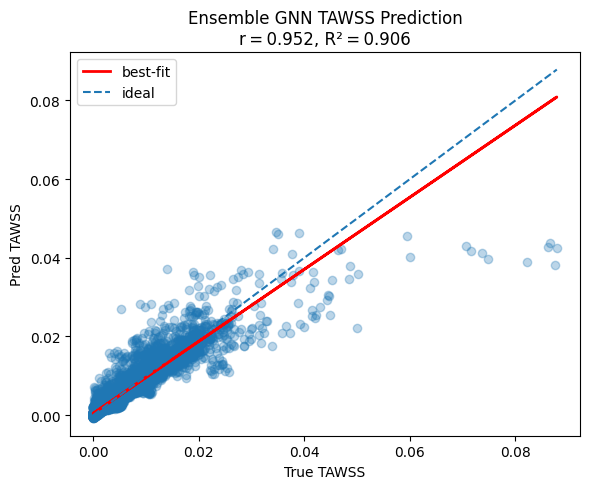

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── 1.  Ensemble predictions ────────────────────────────────────────────
all_preds, all_trues = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        # gather each model’s output
        outs = [m(batch) for m in ensemble_models]          # list[Tensor, …]
        mean_out = torch.stack(outs, dim=0).mean(dim=0)     # [batch_size, n_targets]

        all_preds.append(mean_out.cpu())
        all_trues.append(batch.y.cpu())

preds = torch.cat(all_preds, dim=0)
trues = torch.cat(all_trues, dim=0)

# ── 2.  Un‑normalize ────────────────────────────────────────────────────
preds = preds * y_std + y_mean
trues = trues * y_std + y_mean

preds = preds.numpy()
trues = trues.numpy()

labels = ["TAWSS"]

for i, lbl in enumerate(labels):
    y_true = trues[:, i]
    y_pred = preds[:, i]

    # ---- least‑squares line ----
    slope, intercept = np.polyfit(y_true, y_pred, deg=1)
    line = slope * y_true + intercept

    # ---- metrics ----
    r,  _ = pearsonr(y_true, y_pred)
    r2     = r2_score(y_true, y_pred)

    print(f"\n{lbl}")
    print(f"  slope      = {slope:.3f}")
    print(f"  intercept  = {intercept:.3f}")
    print(f"  Pearson r  = {r:.3f}")
    print(f"  R²         = {r2:.3f}")

    # ---- plot ----
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot(y_true, line, color="red", linewidth=2, label="best‑fit")   # ← red line
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn, mx], [mn, mx], linestyle="--", label="ideal")          # y = x
    plt.xlabel(f"True {lbl}")
    plt.ylabel(f"Pred {lbl}")
    plt.title(f"Ensemble GNN {lbl} Prediction\n"
              f"r = {r:.3f}, R² = {r2:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()


Linear     | RMSE = 1.0742e-03 | R² = 0.9068
Log–Log    | RMSE = 1.0084e-03 | R² = 0.9178
Non-Lin    | RMSE = 9.8634e-04 | R² = 0.9214
Quadratic  | RMSE = 9.2372e-04 | R² = 0.9311


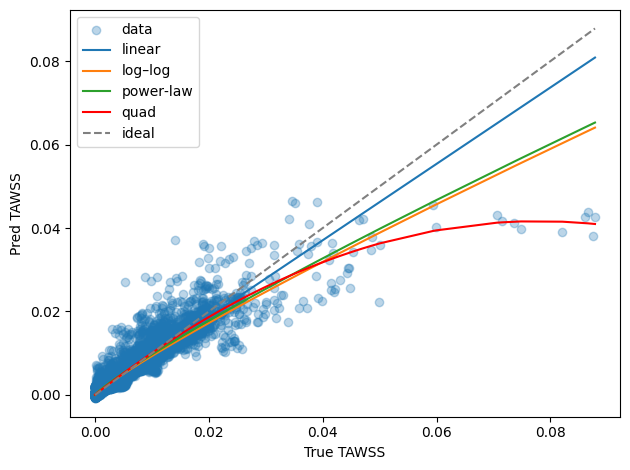

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from scipy.optimize import curve_fit        # ← new
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch

# … your ensemble + un-normalize code …

labels = ["TAWSS"]

def power_model(x, a, b):
    # original y = a * x^(1/b)
    return a * x**(1.0/b)

for i, lbl in enumerate(labels):
    y_true = trues[:, i]
    y_pred = preds[:, i]

    # ---- 1) Linear recalibration ----
    slope, intercept = np.polyfit(y_true, y_pred, deg=1)
    y_lin = slope * y_true + intercept

    # ---- 2) Log–log quick fit ----
    mask = (y_true > 0) & (y_pred > 0)
    log_y  = np.log(y_true[mask])
    log_py = np.log(y_pred[mask])
    beta, log_alpha = np.polyfit(log_y, log_py, 1)
    alpha = np.exp(log_alpha)
    y_log = alpha * (y_true ** beta)

    # ---- 3) Non-linear least squares ----
    # initial guesses: a≈1, b≈1
    popt, _ = curve_fit(power_model, y_true, y_pred, p0=(1.0, 1.0))
    a_nl, b_nl = popt
    y_nl = power_model(y_true, a_nl, b_nl)

    # 4) Quadratic fit on the original scale
    #    ŷ = p2*y_true^2 + p1*y_true + p0
    p2, p1, p0 = np.polyfit(y_true, y_pred, deg=2)
    y_quad = p2 * y_true**2 + p1 * y_true + p0

    # 5) Compute metrics
    for name, y_fit in [
        ("Linear",    y_lin),
        ("Log–Log",   y_log),
        ("Non-Lin",   y_nl),
        ("Quadratic", y_quad),
    ]:
        rmse = np.sqrt(mean_squared_error(y_pred, y_fit))
        r2   = r2_score(y_pred, y_fit)
        print(f"{name:10s} | RMSE = {rmse:.4e} | R² = {r2:.4f}")

    # 6) (Optional) Plot to compare — everything in sorted order
    import matplotlib.pyplot as plt

    # sort once
    idx = np.argsort(y_true)
    y_s   = y_true[idx]
    lin_s = y_lin[idx]
    log_s = y_log[idx]
    nl_s  = y_nl[idx]
    quad_s= y_quad[idx]

    plt.scatter(y_true, y_pred, alpha=0.3, label="data")
    plt.plot(y_s, lin_s,    label="linear")
    plt.plot(y_s, log_s,    label="log–log")
    plt.plot(y_s, nl_s,     label="power‐law")
    plt.plot(y_s, quad_s,   label="quad", color="red")
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn, mx], [mn, mx], "--", color="gray", label="ideal")
    plt.xlabel(f"True {lbl}")
    plt.ylabel(f"Pred {lbl}")
    plt.legend()
    plt.tight_layout()
    plt.show()




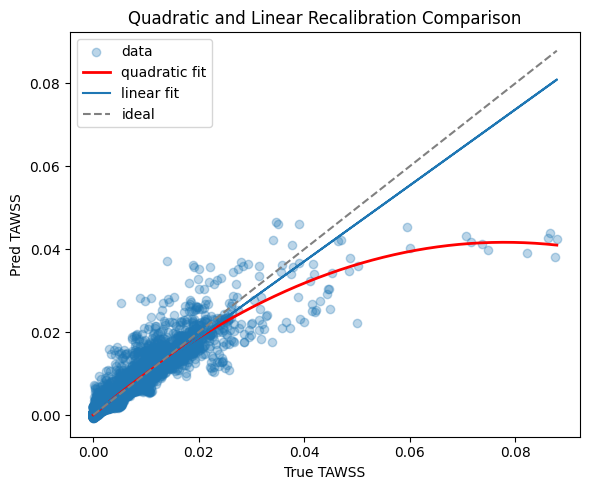

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# — assume y_true, y_pred are defined from your model —

# 1) Fit quadratic ŷ = p2·y_true² + p1·y_true + p0
p2, p1, p0 = np.polyfit(y_true, y_pred, deg=2)

# 2) Build a smooth x-axis over the true-range
x_smooth = np.linspace(y_true.min(), y_true.max(), 300)

# 3) Evaluate the quadratic on that grid
y_quad_smooth = p2 * x_smooth**2 + p1 * x_smooth + p0

# 4) Plot just data + quadratic
plt.figure(figsize=(6, 5))
plt.scatter(y_true, y_pred, alpha=0.3, label="data")
plt.plot(x_smooth, y_quad_smooth, color="red", lw=2, label="quadratic fit")
# plot original linear regression
plt.plot(y_true, y_lin, label="linear fit")

mn, mx = y_true.min(), y_true.max()
plt.plot([mn, mx], [mn, mx], "--", color="gray", label="ideal")
plt.xlabel("True TAWSS")
plt.ylabel("Pred TAWSS")
plt.title("Quadratic and Linear Recalibration Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!zip -r fold_best_states.zip fold_best_states

  adding: fold_best_states/ (stored 0%)
  adding: fold_best_states/best_state_fold_1.pt (deflated 10%)
  adding: fold_best_states/best_state_fold_0.pt (deflated 10%)
  adding: fold_best_states/best_state_fold_2.pt (deflated 9%)
